# Import library

In [2]:
import keras
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import os
from sklearn.metrics.pairwise import cosine_similarity
from keras.models import load_model
from keras.models import Sequential
from keras import layers
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization, GlobalAveragePooling2D
from keras import regularizers
from random import randint

Using TensorFlow backend.


# Read orl_faces data


In [5]:
path = './dataset/orl_faces/'

IMAGE_SIZE = (32, 32)
# 1-hot encoding
a = np.array([i for i in range(43)])
classes = np.zeros((a.size, a.max() + 1))
classes[np.arange(a.size), a] = 1

train_array = []
test_array = []
dir_array = []

# let random index and 9th(enumerate begins at 0 so index 8 represents image 9) pgm for test
for dir in os.listdir(path):
    i1, i2 = 8, randint(0, 7)
    for idx, img in enumerate(sorted(os.listdir(path + dir))):
        image = cv2.imread(path + dir + '/' + img, 0)
        image = cv2.resize(image, IMAGE_SIZE)
        image = image[:, :, np.newaxis]
        if idx == i1 or idx == i2:
            test_array.append((image, classes[os.listdir(path).index(dir)]))
            continue

        train_array.append((image, classes[os.listdir(path).index(dir)]))
    dir_array.append(dir)

In [6]:
len(train_array), len(test_array), len(dir_array)

(344, 86, 43)

# Split train_images and test_images


In [7]:
train_images, train_labels = np.array([t[0] for t in train_array]), np.array([t[1] for t in train_array])
test_images, test_labels = np.array([t[0] for t in test_array]), np.array([t[1] for t in test_array])

# Plot some sample of train_images


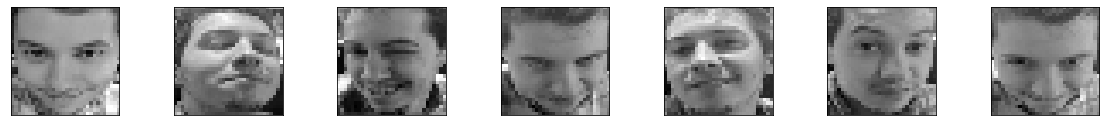

In [8]:
n = 7
plt.figure(figsize=(20, 2))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(train_images[i].reshape(32, 32))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Normalize train_images and test_images


In [9]:
x_train = train_images.astype('float32') / 255.
x_test = test_images.astype('float32') / 255.

# Add some noise 


In [10]:
noise_factor = 0.01
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

# Plot noisy images


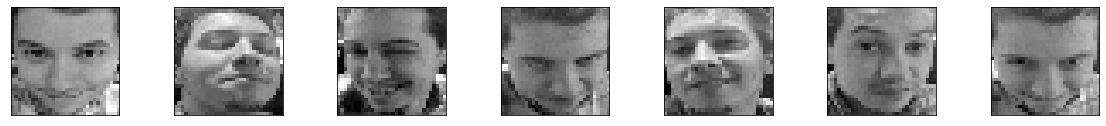

In [11]:
n = 7
plt.figure(figsize=(20, 2))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_train_noisy[i].reshape(32, 32))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Reshape images for using deep autoencoder


In [12]:
x_train = x_train_noisy.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test_noisy.reshape((len(x_test), np.prod(x_test.shape[1:])))
x_train = np.reshape(x_train, (len(x_train), 32, 32, 1))
x_test = np.reshape(x_test, (len(x_test), 32, 32, 1))
print(x_train.shape)
print(x_test.shape)

(344, 32, 32, 1)
(86, 32, 32, 1)


# Deep convotional autoencoder


In [16]:
input_img = keras.Input(shape=(32, 32, 1))

x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', activity_regularizer=regularizers.l1(10e-5))(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', activity_regularizer=regularizers.l1(10e-5))(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', activity_regularizer=regularizers.l1(10e-5))(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', activity_regularizer=regularizers.l1(10e-5))(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same', activity_regularizer=regularizers.l1(10e-5))(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same', activity_regularizer=regularizers.l1(10e-5))(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (1, 1), activation='relu')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(64, (1, 1), activation='relu')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(64, (1, 1), activation='relu')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(128, (1, 1), activation='relu')(x)
x = layers.UpSampling2D((1, 1))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# This model maps an input to its reconstruction
autoencoder = keras.Model(input_img, decoded)
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 32, 128)       1280      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 16, 16, 64)        73792     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 8, 8, 64)          36928     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 4, 4, 64)          0   

In [17]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [18]:
autoencoder.fit(x_train, x_train,
                epochs=30,
                batch_size=32,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 344 samples, validate on 86 samples
Epoch 1/30
344/344 [==============================] - 7s 20ms/step - loss: 7.3837 - val_loss: 3.1154
Epoch 2/30
344/344 [==============================] - 7s 20ms/step - loss: 1.9553 - val_loss: 0.9590
Epoch 3/30
344/344 [==============================] - 7s 19ms/step - loss: 0.7860 - val_loss: 0.6989
Epoch 4/30
344/344 [==============================] - 7s 19ms/step - loss: 0.6958 - val_loss: 0.6931
Epoch 5/30
344/344 [==============================] - 7s 19ms/step - loss: 0.6922 - val_loss: 0.6913
Epoch 6/30
344/344 [==============================] - 7s 19ms/step - loss: 0.6907 - val_loss: 0.6901
Epoch 7/30
344/344 [==============================] - 7s 20ms/step - loss: 0.6894 - val_loss: 0.6889
Epoch 8/30
344/344 [==============================] - 7s 20ms/step - loss: 0.6881 - val_loss: 0.6873
Epoch 9/30
344/344 [==============================] - 7s 20ms/step - loss: 0.6864 - val_loss: 0.6857
Epoch 10/30
344/344 [=========================

<AxesSubplot:>

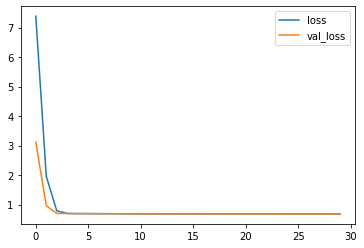

In [19]:
model_loss_history = pd.DataFrame({'loss': autoencoder.history.history['loss'],
                                   'val_loss': autoencoder.history.history['val_loss']})
model_loss_history.plot()

In [20]:
autoencoder.evaluate(x=x_test, y=x_test)

86/86 [==============================] - 0s 3ms/step


0.6807374871054361

# Reshape images for face_recognition_model

In [21]:
x_train = np.reshape(x_train, (len(x_train), 32, 32, 1))
x_test = np.reshape(x_test, (len(x_test), 32, 32, 1))

# face_recognition_model


In [25]:
input_shape = (32, 32, 1)

face_recognition_model = Sequential()
#  BLOCK 1
# convolutional layer 16 windows/filters of 3x3
face_recognition_model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu',
                     kernel_regularizer=regularizers.l2(0.),
                     activity_regularizer=regularizers.l2(0.),
                     input_shape=input_shape))

# max of each 2x2 block
face_recognition_model.add(MaxPooling2D(pool_size=(2, 2)))
# normalization
face_recognition_model.add(BatchNormalization())
# avoid overfitting
face_recognition_model.add(Dropout(0.25))

#  BLOCK 2
face_recognition_model.add(Conv2D(filters=32, kernel_size=(3, 3),
                     activation='relu',
                     kernel_regularizer=regularizers.l2(0.),
                     activity_regularizer=regularizers.l2(0.)))

face_recognition_model.add(MaxPooling2D(pool_size=(2, 2)))
face_recognition_model.add(BatchNormalization())
face_recognition_model.add(Dropout(0.25))

# flatten for final layers
face_recognition_model.add(Flatten())

# fully-connected layer
face_recognition_model.add(Dense(3000, activation='relu',kernel_regularizer=regularizers.l2(0.),
                activity_regularizer=regularizers.l2(0.)))
face_recognition_model.add(Dropout(0.25))

face_recognition_model.add(Dense(units=43, activation='softmax'))

face_recognition_model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 30, 30, 16)        160       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 15, 15, 16)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 15, 15, 16)        64        
_________________________________________________________________
dropout_4 (Dropout)          (None, 15, 15, 16)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 13, 13, 32)        4640      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 6, 6, 32)          0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 6, 6, 32)         

In [26]:
face_recognition_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [27]:
history = face_recognition_model.fit(train_images, train_labels,
                        batch_size=20,
                        epochs=12,
                        verbose=2,
                        validation_data=(test_images, test_labels))

Train on 344 samples, validate on 86 samples
Epoch 1/12
 - 2s - loss: 2.7187 - accuracy: 0.4186 - val_loss: 24.7173 - val_accuracy: 0.0233
Epoch 2/12
 - 1s - loss: 0.4788 - accuracy: 0.8605 - val_loss: 11.9864 - val_accuracy: 0.1744
Epoch 3/12
 - 1s - loss: 0.0935 - accuracy: 0.9738 - val_loss: 11.8632 - val_accuracy: 0.1395
Epoch 4/12
 - 1s - loss: 0.0520 - accuracy: 0.9913 - val_loss: 6.5189 - val_accuracy: 0.3140
Epoch 5/12
 - 1s - loss: 0.0115 - accuracy: 1.0000 - val_loss: 4.3666 - val_accuracy: 0.4070
Epoch 6/12
 - 1s - loss: 0.0133 - accuracy: 0.9971 - val_loss: 3.3109 - val_accuracy: 0.4535
Epoch 7/12
 - 1s - loss: 0.0107 - accuracy: 0.9942 - val_loss: 1.7422 - val_accuracy: 0.5465
Epoch 8/12
 - 1s - loss: 0.0200 - accuracy: 0.9942 - val_loss: 1.2388 - val_accuracy: 0.6047
Epoch 9/12
 - 1s - loss: 0.0153 - accuracy: 0.9942 - val_loss: 1.0951 - val_accuracy: 0.7442
Epoch 10/12
 - 1s - loss: 0.0253 - accuracy: 0.9913 - val_loss: 0.8597 - val_accuracy: 0.7674
Epoch 11/12
 - 1s - l

<AxesSubplot:>

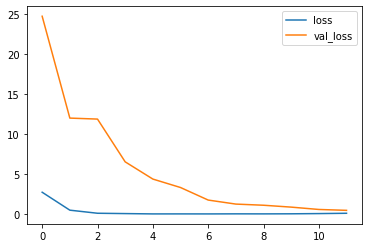

In [28]:
model_loss_history = pd.DataFrame({'loss': face_recognition_model.history.history['loss'],
                                   'val_loss': face_recognition_model.history.history['val_loss']})
model_loss_history.plot()

<AxesSubplot:>

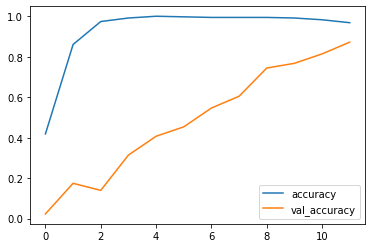

In [29]:
model_accuracy_history = pd.DataFrame({'accuracy': face_recognition_model.history.history['accuracy'],
                                       'val_accuracy': face_recognition_model.history.history['val_accuracy']})
model_accuracy_history.plot()

In [30]:
face_recognition_model.evaluate(x=test_images, y=test_labels)

86/86 [==============================] - 0s 430us/step


[0.45711140715798665, 0.8720930218696594]

# Save model

In [31]:
face_recognition_model.save('conv_model.h5')  # creates a HDF5 file 'conv_model.h5'

# Evaluate model


In [42]:
def evaluate_model(test_images, test_labels, classes, dir_array):
    # returns a compiled model
    # identical to the previous one
    model = load_model('conv_model.h5')

    score = model.evaluate(test_images, test_labels, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

    # evaluate test images added in the orl database
    imageindex = 9

    pathsorin1 = './dataset/orl_faces/sorin/' + str(imageindex) + '.pgm'
    sorin1 = cv2.imread(pathsorin1, cv2.IMREAD_UNCHANGED)
    #cv2.imshow("imageofsorin", sorin1)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    sorin1 = cv2.resize(sorin1, (32, 32))
    sorin1 = sorin1[:, :, np.newaxis]

    
    imageindex = 9

    pathandreea1 = './dataset/orl_faces/andreea/' + str(imageindex) + '.pgm'
    andreea1 = cv2.imread(pathandreea1, cv2.IMREAD_UNCHANGED)
    #cv2.imshow("imageofandreea", andreea1)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    andreea1 = cv2.resize(andreea1, (32, 32))
    andreea1 = andreea1[:, :, np.newaxis]

    imageindex = 9

    pathalex1 = './dataset/orl_faces/alex/' + str(imageindex) + '.pgm'
    alex1 = cv2.imread(pathalex1, cv2.IMREAD_UNCHANGED)
    #cv2.imshow("imageofalex", alex1)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    alex1 = cv2.resize(alex1, (32, 32))
    alex1 = alex1[:, :, np.newaxis]

    people_test_image = np.array([sorin1, andreea1, alex1])
    [prediction1, prediction2, prediction3] = model.predict(people_test_image)

    a = max([(c, cosine_similarity([prediction1], [c])) for c in classes], key=lambda t:t[1])
    b = max([(c, cosine_similarity([prediction2], [c])) for c in classes], key=lambda t:t[1])
    c = max([(c, cosine_similarity([prediction3], [c])) for c in classes], key=lambda t:t[1])

    print(dir_array[list(a[0]).index(1)])
    print(dir_array[list(b[0]).index(1)])
    print(dir_array[list(c[0]).index(1)])

In [43]:
evaluate_model(test_images, test_labels, classes, dir_array)


Test loss: 0.45711140715798665
Test accuracy: 0.8720930218696594
sorin
andreea
alex
